**Group Members**

1. Kotchakorn Ruenagsri

2. Thontanvarot Srisamruan

3. Tanita Jaipuang


# **Load Dependencies**

In [ ]:
!pip install pycaret

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from datetime import datetime
from pycaret.clustering import *
from scipy import stats

# **1. Load and Prepare Data**

In [ ]:
# Load Data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/Customer Analysis/Supermarket Data.csv'
#'/content/drive/MyDrive/Colab Notebooks/Customer Analysis/Supermarket Data.csv'
df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.info

<bound method DataFrame.info of         SHOP_WEEK  SHOP_DATE  SHOP_WEEKDAY  SHOP_HOUR  QUANTITY  SPEND  \
0          200732   20071005             6         17         3   6.75   
1          200733   20071010             4         20         3   6.75   
2          200741   20071209             1         11         1   2.25   
3          200731   20070929             7         17         1   2.25   
4          200737   20071110             7         14         3   6.75   
...           ...        ...           ...        ...       ...    ...   
956569     200617   20060622             5         12         3   3.96   
956570     200633   20061013             6         20         3   3.96   
956571     200617   20060622             5         18         3   3.96   
956572     200619   20060706             5         19         3   3.96   
956573     200635   20061023             2         21         3   3.96   

         PROD_CODE PROD_CODE_10 PROD_CODE_20 PROD_CODE_30 PROD_CODE_40  \
0    

In [ ]:
# Create Unique Basket
df['UNIQUE_BASKET'] = df['SHOP_DATE'].astype(str)+'_'+df['SHOP_HOUR'].astype(str)+'_'+df['BASKET_ID'].astype(str)
df['SHOP_DATE'] = df['SHOP_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [ ]:
df

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION,UNIQUE_BASKET
0,200732,2007-10-05,6,17,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000583261,UM,YF,9.941080e+14,L,MM,Top Up,Grocery,STORE00001,LS,E02,20071005_17_994108000000000.0
1,200733,2007-10-10,4,20,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000537317,MM,OF,9.941080e+14,L,MM,Full Shop,Fresh,STORE00001,LS,E02,20071010_20_994108000000000.0
2,200741,2007-12-09,1,11,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000472158,MM,YF,9.941090e+14,L,MM,Full Shop,Grocery,STORE00001,LS,E02,20071209_11_994109000000000.0
3,200731,2007-09-29,7,17,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000099658,LA,OF,9.941080e+14,L,LA,Full Shop,Mixed,STORE00001,LS,E02,20070929_17_994108000000000.0
4,200737,2007-11-10,7,14,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,NaN,NaN,NaN,9.941080e+14,L,MM,Full Shop,Fresh,STORE00001,LS,E02,20071110_14_994108000000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956569,200617,2006-06-22,5,12,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,NaN,NaN,NaN,9.941010e+14,M,MM,Top Up,Fresh,STORE00002,LS,W01,20060622_12_994101000000000.0
956570,200633,2006-10-13,6,20,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,NaN,NaN,NaN,9.941030e+14,L,LA,Top Up,Fresh,STORE00002,LS,W01,20061013_20_994103000000000.0
956571,200617,2006-06-22,5,18,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000544241,LA,YA,9.941010e+14,L,LA,Top Up,Fresh,STORE00002,LS,W01,20060622_18_994101000000000.0
956572,200619,2006-07-06,5,19,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000423155,LA,YF,9.941010e+14,L,LA,Full Shop,Fresh,STORE00002,LS,W01,20060706_19_994101000000000.0


# **2. Feature Extraction - Prepare customer single view**

##     Define features

Total visits = COUNT(DISTINCT BASKET ID)

Ticket size = SUM(SPEND)/COUNT(DISTINCT BASKET ID)

**Customer Profile :**
1.  Customer's Lifestage
     - 1 = YA : Young Adults
     - 2 = OA : Older Adults
     - 3 = YF : Young Families
     - 4 = OF : Older Families
     - 5 = PE : Pensioners
     - 6 = OT : Other
     - 0 = XX : Unclassified
2.  Customer' Price Sensitivity
     - 1 = LA : Less Affluent
     - 2 = MM : Mid Market
     - 3 = UM : Up Market
     - 0 = XX : Unclassified

**General RFM :**
1. *Recency = MAX_DATE - Last(SHOP_DATE)
2. *Total Unique Visits = COUNT(DISTINCT UNIQUE_BASKET)
3. *Total Spend

**Purchase Bahavior :**
1. Total Customer Days = Last(SHOP_DATE) - First(SHOP_DATE)
2. Total Active Days = COUNTD(SHOP_DATE)
3. *Purchase Consistency = Total Active Days / Total Customer Days >> Weekly
4. *Mean Time Between Purchase (MTBP)
5. *Most SHOP_WEEKDAY
6. *Most SHOP_HOUR
7. *Proportion of Most SHOP_WEEKDAY
8. *Proportion of Most SHOP_HOUR

**Spending Behavior :**
1. *Ticket size = SUM(SPEND)/COUNT(DISTINCT UNIQUE_BASKET) >> Mean Spend
2. *AVG Spending per Active Week
3. *STD Ticket size


**Product Purchase Behavior :**
1. *Repurchase Index (Repeat Product Index) = Number of Item Purchase / Number of Product Purchase
2. AVG Product Per Basket
3. STD Product Per Basket
4. *Proportion of Top Product by Amount
5. *Proportion of Top Product by Value


**Basket Behavior :**
1.   Basket Dominant Mission_Spend
2.   Basket Size (L,M,S)_Spend
3.   Basket Type (Small Shop,Top Up,Full Shop)_Spend
4.   Basket Price Sensitivity_Spend

**Store Behavior :**
1.   Store Region





##         Calculate features

In [ ]:
##prepare customer single view
df_csv = df_groupby = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE']).agg(TotalSpend=('SPEND', 'sum'),
                                                                                  TotalUniqueVisits=('UNIQUE_BASKET', 'nunique'),
                                                                                  TotalVisits=('BASKET_ID', 'nunique'),
                                                                                  TotalUniqueSKUs=('PROD_CODE', 'nunique'),
                                                                                  TotalSKUs=('PROD_CODE', 'count'),
                                                                                  FirstDate=('SHOP_DATE', 'min'),
                                                                                  LastDate=('SHOP_DATE', 'max'),
                                                                                  SHOP_WEEKDAYS=('SHOP_WEEKDAY',lambda x: stats.mode(x)[0][0]),
                                                                                  SHOP_HOURS = ('SHOP_HOUR',lambda x: stats.mode(x)[0][0])
                                                                                  ).reset_index()        

In [ ]:
df_csv

,CUST_CODE,TotalSpend,TotalUniqueVisits,TotalVisits,TotalUniqueSKUs,TotalSKUs,FirstDate,LastDate,SHOP_WEEKDAYS,SHOP_HOURS
0,CUST0000000181,2.44,1,1,1,1,2007-01-06,2007-01-06,7,13
1,CUST0000000369,959.33,217,13,189,699,2006-04-16,2008-07-05,6,17
2,CUST0000000689,328.57,16,5,116,185,2007-07-22,2008-06-23,2,21
3,CUST0000000998,5.95,3,2,4,4,2006-05-04,2006-07-07,1,8
4,CUST0000001163,39.74,4,3,24,25,2006-10-22,2008-06-22,1,16
...,...,...,...,...,...,...,...,...,...,...
6095,CUST0000999593,453.58,30,10,206,297,2006-05-06,2008-04-02,1,16
6096,CUST0000999645,105.11,11,5,46,60,2006-04-30,2008-05-08,1,17
6097,CUST0000999654,5.86,1,1,4,4,2006-06-25,2006-06-25,1,14
6098,CUST0000999935,444.17,21,9,127,236,2006-11-29,2008-06-05,4,16


In [ ]:
# PART 1 : CUSTOMER PROFILE
# 1.1) Customer Lifestage
df_cust_lifestage = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE','CUST_LIFESTAGE']).agg(TotalSpend=('SPEND', 'sum')).reset_index()[['CUST_CODE','CUST_LIFESTAGE']]

# Change value in CUST_LIFESTAGE
df_cust_lifestage['CUST_LIFESTAGE'] = df_cust_lifestage['CUST_LIFESTAGE'].replace(['YA','OA','YF','OF','PE','OT','XX'],['1','2','3','4','5','6','0'])

df_cust_lifestage.head(5)

,CUST_CODE,CUST_LIFESTAGE
0,CUST0000000369,2
1,CUST0000001194,6
2,CUST0000002257,1
3,CUST0000002499,3
4,CUST0000002605,6


In [ ]:
# 1.2) Customer Price Sensivity
df_cust_price_sensitivity = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE','CUST_PRICE_SENSITIVITY']).agg(TotalSpend=('SPEND', 'sum')).reset_index()[['CUST_CODE','CUST_PRICE_SENSITIVITY']]

# Change value in CUST_PRICE_SENSITIVITY
df_cust_price_sensitivity['CUST_PRICE_SENSITIVITY'] = df_cust_price_sensitivity['CUST_PRICE_SENSITIVITY'].replace(['LA','MM','UM','XX'],['1','2','3','0'])

df_cust_price_sensitivity.head(5)

,CUST_CODE,CUST_PRICE_SENSITIVITY
0,CUST0000000181,2
1,CUST0000000369,2
2,CUST0000000689,1
3,CUST0000000998,0
4,CUST0000001163,2


In [ ]:
# 1) Dataframe : Customer Profile
df_customer_profile_final = df_cust_price_sensitivity
df_customer_profile_final = pd.merge(df_customer_profile_final, df_cust_lifestage, how= 'left', on ='CUST_CODE').fillna(0)

df_customer_profile_final.head(5)

,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE
0,CUST0000000181,2,0
1,CUST0000000369,2,2
2,CUST0000000689,1,0
3,CUST0000000998,0,0
4,CUST0000001163,2,0


In [ ]:
# PART 2 : GENERAL RFM 
## Find max date in the dataset
MaxDate = df_csv['LastDate'].max()
df_csv['MaxDate'] = df_csv['LastDate'].max()

## Calculate Recentcy Days
df_csv['Recency'] = (MaxDate - df_csv['LastDate']).dt.days

df_csv.head(5)

,CUST_CODE,TotalSpend,TotalUniqueVisits,TotalVisits,TotalUniqueSKUs,TotalSKUs,FirstDate,LastDate,SHOP_WEEKDAYS,SHOP_HOURS,MaxDate,Recency
0,CUST0000000181,2.44,1,1,1,1,2007-01-06,2007-01-06,7,13,2008-07-06,547
1,CUST0000000369,959.33,217,13,189,699,2006-04-16,2008-07-05,6,17,2008-07-06,1
2,CUST0000000689,328.57,16,5,116,185,2007-07-22,2008-06-23,2,21,2008-07-06,13
3,CUST0000000998,5.95,3,2,4,4,2006-05-04,2006-07-07,1,8,2008-07-06,730
4,CUST0000001163,39.74,4,3,24,25,2006-10-22,2008-06-22,1,16,2008-07-06,14


In [ ]:
## PART 3 : PURCHASE BEHAVIOR
## 3.1) Calculate Total Customer Days( Total Days of the relationship)
df_csv['TotalCustomerDays'] = (df_csv['LastDate'] - df_csv['FirstDate']).dt.days + 1
#df_shopweek = df.groupby(by='CUST_CODE').agg(ShopWeek=('SHOP_WEEK','nunique')).reset_index()
#df_csv['TotalCustomerDays'] = df_csv['TotalCustomerDays']/df_shopweek['ShopWeek']

## 3.2) Calulate Total Active Days
df_TotalActiveDays = df.groupby(by = 'CUST_CODE').agg(TotalActiveDays = ('SHOP_DATE','nunique')).reset_index()
#df_csv['TotalActiveDays'] = df_TotalActiveDays['TotalActiveDays']/df_shopweek['ShopWeek']

## 3.4) Calulate Purchase Consistency (Week)
lifetime = df.sort_values(by=['CUST_CODE','SHOP_DATE'], ascending=True).drop_duplicates(subset=['CUST_CODE'])
lifetime = lifetime[~(lifetime['CUST_CODE'].isnull())]
lifetime['MAX_DATE'] = MaxDate
lifetime['LIFETIME_DAYS'] = (lifetime['MAX_DATE'] - lifetime['SHOP_DATE']).dt.days
lifetime['LIFETIME_WEEKS'] = lifetime['LIFETIME_DAYS']/7
lifetime = lifetime[['CUST_CODE','LIFETIME_WEEKS']]
#display(lifetime.head(3))
active_weeks = df.groupby(by=['CUST_CODE']).agg(TTL_ACTIVE_WEEKS = ('SHOP_WEEK','nunique')).reset_index()
#display(active_weeks.head(3))
df_combined = active_weeks.merge(lifetime, on=['CUST_CODE'])
df_combined['PurchaseConsistencyWeek'] = df_combined['TTL_ACTIVE_WEEKS']/df_combined['LIFETIME_WEEKS']
#df_combined

## 3.5) Mean time between purchase (MTBP)
df_Group = df.groupby(by=['CUST_CODE','SHOP_DATE']).agg(total_spend=('SPEND','sum')).reset_index()
df_Group['LAST_SHOP_DATE'] = df_Group.groupby('CUST_CODE')['SHOP_DATE'].shift(1)
df_Group['DAY_FROM_LAST_PURCHASE'] =  (df_Group['SHOP_DATE'] - df_Group['LAST_SHOP_DATE']).dt.days
df_MTBP = df_Group.groupby('CUST_CODE').agg(MTBP = ('DAY_FROM_LAST_PURCHASE','mean')).reset_index()

In [ ]:
# 3.6) Most SHOP_WEEKSDAYS
# 1) Calculate Weekday : Count distinct Unique Basket group by cust_code, shop_weekday
df_weekday = df.groupby(['CUST_CODE','SHOP_WEEKDAY']).agg({'UNIQUE_BASKET' : 'nunique'}).reset_index()

# 2) For each Cust code, we need to sort the Prod code by the Txn in descending order
df_weekday = df_weekday.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['SHOP_WEEKDAY'], ascending = False)).reset_index(drop = True)

# 3) Now for each Cust code, we need to pick the top n records
df_weekday = df_weekday.groupby(['CUST_CODE']).head(1)

# 4) Drop column 'Unique_Basket'
df_weekday = df_weekday.drop(columns = 'UNIQUE_BASKET')

df_weekday.head(5)

,CUST_CODE,SHOP_WEEKDAY
0,CUST0000000181,7
1,CUST0000000369,7
8,CUST0000000689,7
15,CUST0000000998,6
18,CUST0000001163,7


In [ ]:
# 3.7) Most SHOP_HOUR
# 1) Calculate Hour : Count distinct Unique Basket group by cust_code, shop_hour
df_hour = df.groupby(['CUST_CODE','SHOP_HOUR']).agg({'UNIQUE_BASKET':'nunique'}).reset_index()

# 2) For each Cust code, we need to sort the Prod code by the Txn in descending order
df_hour = df_hour.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['SHOP_HOUR'], ascending = False)).reset_index(drop = True)

# 3)Now for each Cust code, we need to pick the top n records
df_hour = df_hour.groupby(['CUST_CODE']).head(1)

# 4) Drop column 'Unique_Basket'
df_hour = df_hour.drop(columns = 'UNIQUE_BASKET')

df_hour.head(5)

,CUST_CODE,SHOP_HOUR
0,CUST0000000181,13
1,CUST0000000369,21
13,CUST0000000689,21
18,CUST0000000998,15
20,CUST0000001163,16


In [ ]:
# 3.8) Proportion of Most SHOP_WEEKDAY
# 1) Sum Spend group by Cust code and Shop Weekday
df_proportion_weekday_product = df.groupby(by=['CUST_CODE','SHOP_WEEKDAY']).agg(ProductSpend = ('SPEND', 'sum')).reset_index()

# 2) Count Txn group by Cust code
df_proportion_weekday = df.groupby(by=['CUST_CODE']).agg(TotalSpend = ('SPEND', 'sum')).reset_index()

# 3) Calculate % Total
df_proportion_weekday = pd.merge(df_proportion_weekday_product, df_proportion_weekday, how = 'left', on = 'CUST_CODE').reset_index()
df_proportion_weekday['ProportionShopWeekDay'] = (df_proportion_weekday_product['ProductSpend']/df_proportion_weekday['TotalSpend'])*100
df_proportion_weekday = df_proportion_weekday.sort_values(by=['ProductSpend'], ascending=True).reset_index()

# 4) For each Cust code, we need to sort the Prod code by the Txn in descending order
df_proportion_weekday = df_proportion_weekday.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['ProductSpend'], ascending = False)).reset_index(drop = True)

# 5) Now for each Cust code, we need to pick the top n records
df_proportion_weekday = df_proportion_weekday.groupby(['CUST_CODE']).head(1)

# 6) Drop column
df_proportion_weekday = df_proportion_weekday.drop(columns = ['level_0', 'index', 'SHOP_WEEKDAY', 'ProductSpend', 'TotalSpend'])

df_proportion_weekday.head(5)

,CUST_CODE,ProportionShopWeekDay
0,CUST0000000181,100.000000
1,CUST0000000369,16.130007
8,CUST0000000689,20.574002
15,CUST0000000998,53.949580
18,CUST0000001163,54.302969


In [ ]:
# 3.9) Proportion of Most SHOP_HOUR

# 1) Sum Spend group by Cust code and Shop Hour
df_proportion_weekhour_product = df.groupby(by=['CUST_CODE','SHOP_HOUR']).agg(ProductSpend = ('SPEND', 'sum')).reset_index()

# 2) Count Txn group by Cust code
df_proportion_weekhour = df.groupby(by=['CUST_CODE']).agg(TotalSpend = ('SPEND', 'sum')).reset_index()

# 3) Calculate % Total
df_proportion_weekhour = pd.merge(df_proportion_weekhour_product, df_proportion_weekhour, how = 'left', on = 'CUST_CODE').reset_index()
df_proportion_weekhour['ProportionShopHour'] = (df_proportion_weekhour_product['ProductSpend']/df_proportion_weekhour['TotalSpend'])*100
df_proportion_weekhour = df_proportion_weekhour.sort_values(by=['ProductSpend'], ascending=True).reset_index()

# 4) For each Cust code, we need to sort the Prod code by the Txn in descending order
df_proportion_weekhour = df_proportion_weekhour.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['ProductSpend'], ascending = False)).reset_index(drop = True)

# 5) Now for each Cust code, we need to pick the top n records
df_proportion_weekhour = df_proportion_weekhour.groupby(['CUST_CODE']).head(1)

# 6) Drop column
df_proportion_weekhour = df_proportion_weekhour.drop(columns = ['level_0', 'index', 'SHOP_HOUR', 'ProductSpend', 'TotalSpend'])

df_proportion_weekhour.head(5)

,CUST_CODE,ProportionShopHour
0,CUST0000000181,100.000000
1,CUST0000000369,18.009444
13,CUST0000000689,48.482819
18,CUST0000000998,53.949580
20,CUST0000001163,54.302969


In [ ]:
# 3) Dataframe : Purchase Bahavior
df_purchase_behavior_final = df_hour
df_purchase_behavior_final = pd.merge(df_purchase_behavior_final, df_weekday, how= 'left', on ='CUST_CODE')
df_purchase_behavior_final = pd.merge(df_purchase_behavior_final, df_combined, how= 'left', on ='CUST_CODE')
df_purchase_behavior_final = pd.merge(df_purchase_behavior_final, df_MTBP, how= 'left', on ='CUST_CODE')
df_purchase_behavior_final = pd.merge(df_purchase_behavior_final, df_proportion_weekday, how= 'left', on ='CUST_CODE')
df_purchase_behavior_final = pd.merge(df_purchase_behavior_final, df_proportion_weekhour, how= 'left', on ='CUST_CODE')

df_purchase_behavior_final.head(5)

,CUST_CODE,SHOP_HOUR,SHOP_WEEKDAY,TTL_ACTIVE_WEEKS,LIFETIME_WEEKS,PurchaseConsistencyWeek,MTBP,ProportionShopWeekDay,ProportionShopHour
0,CUST0000000181,13,7,1,78.142857,0.012797,NaN,100.000000,100.000000
1,CUST0000000369,21,7,103,116.000000,0.887931,4.246073,16.130007,18.009444
2,CUST0000000689,21,7,13,50.000000,0.260000,22.466667,20.574002,48.482819
3,CUST0000000998,15,6,3,113.428571,0.026448,32.000000,53.949580,53.949580
4,CUST0000001163,16,7,4,89.000000,0.044944,203.000000,54.302969,54.302969


In [ ]:
# PART 4 : SPENDING BEHAVIOR
df_spending_behavior_01 = df.groupby(by=['CUST_CODE']).agg(Total_Spend=('SPEND','sum'),Total_Unique_Visits=('UNIQUE_BASKET', 'nunique'), Total_Active_Week=('SHOP_WEEK','nunique')).reset_index()

# 4.1 Average Ticket Size
df_spending_behavior_01['AVG_TICKET_SIZE'] = df_spending_behavior_01['Total_Spend']/df_spending_behavior_01['Total_Unique_Visits']

# 4.2 Average Spending per Active Week
df_spending_behavior_01['AVG_ACTIVE_WEEKLY_SPEND'] = df_spending_behavior_01['Total_Spend']/df_spending_behavior_01['Total_Active_Week']

df_spending_behavior_01

,CUST_CODE,Total_Spend,Total_Unique_Visits,Total_Active_Week,AVG_TICKET_SIZE,AVG_ACTIVE_WEEKLY_SPEND
0,CUST0000000181,2.44,1,1,2.440000,2.440000
1,CUST0000000369,959.33,217,103,4.420876,9.313883
2,CUST0000000689,328.57,16,13,20.535625,25.274615
3,CUST0000000998,5.95,3,3,1.983333,1.983333
4,CUST0000001163,39.74,4,4,9.935000,9.935000
...,...,...,...,...,...,...
6095,CUST0000999593,453.58,30,26,15.119333,17.445385
6096,CUST0000999645,105.11,11,10,9.555455,10.511000
6097,CUST0000999654,5.86,1,1,5.860000,5.860000
6098,CUST0000999935,444.17,21,19,21.150952,23.377368


In [ ]:
# 4.3 STD Ticket Size by Customer
#spending_behavior_02 = df.groupby(by=['CUST_CODE','SHOP_DATE','SHOP_HOUR']).agg(Ticket_Size=('SPEND','sum')).reset_index().groupby(by='CUST_CODE').agg(AVG_CUST_TICKET = ('Ticket_Size','mean'),STD_CUST_TICKET = ('Ticket_Size','std')).reset_index()
df_spending_behavior_02 = df.groupby(by=['CUST_CODE','SHOP_DATE','SHOP_HOUR']).agg(Ticket_Size=('SPEND','sum')).reset_index().groupby(by='CUST_CODE').agg(STD_CUST_TICKET = ('Ticket_Size','std')).reset_index()
df_spending_behavior_02

,CUST_CODE,STD_CUST_TICKET
0,CUST0000000181,NaN
1,CUST0000000369,4.123919
2,CUST0000000689,19.922842
3,CUST0000000998,1.187196
4,CUST0000001163,11.022926
...,...,...
6095,CUST0000999593,9.752229
6096,CUST0000999645,10.161866
6097,CUST0000999654,NaN
6098,CUST0000999935,20.343842


In [ ]:
# 4) Dataframe : Spending Behavior
df_spending_behavior_final = df_spending_behavior_01.merge(df_spending_behavior_02,on=['CUST_CODE'])

df_spending_behavior_final

,CUST_CODE,Total_Spend,Total_Unique_Visits,Total_Active_Week,AVG_TICKET_SIZE,AVG_ACTIVE_WEEKLY_SPEND,STD_CUST_TICKET
0,CUST0000000181,2.44,1,1,2.440000,2.440000,NaN
1,CUST0000000369,959.33,217,103,4.420876,9.313883,4.123919
2,CUST0000000689,328.57,16,13,20.535625,25.274615,19.922842
3,CUST0000000998,5.95,3,3,1.983333,1.983333,1.187196
4,CUST0000001163,39.74,4,4,9.935000,9.935000,11.022926
...,...,...,...,...,...,...,...
6095,CUST0000999593,453.58,30,26,15.119333,17.445385,9.752229
6096,CUST0000999645,105.11,11,10,9.555455,10.511000,10.161866
6097,CUST0000999654,5.86,1,1,5.860000,5.860000,NaN
6098,CUST0000999935,444.17,21,19,21.150952,23.377368,20.343842


In [ ]:
# PART 5 : PRODUCT PURCHASE BEHAVIOR
# 5.1) Number of Product Purchase, 5.2) Number of Item Purchase
product_purchase_behavior_01 = df.groupby(by=['CUST_CODE']).agg(product_pur=('PROD_CODE','nunique'),
                                                            item_pur = ('PROD_CODE','count')
                                                            ).reset_index()
product_purchase_behavior_01['repeat_product_index'] = product_purchase_behavior_01['item_pur']/product_purchase_behavior_01['product_pur']

product_purchase_behavior_01 = product_purchase_behavior_01.drop(columns = ['product_pur','item_pur'])

product_purchase_behavior_01

,CUST_CODE,repeat_product_index
0,CUST0000000181,1.000000
1,CUST0000000369,3.698413
2,CUST0000000689,1.594828
3,CUST0000000998,1.000000
4,CUST0000001163,1.041667
...,...,...
6095,CUST0000999593,1.441748
6096,CUST0000999645,1.304348
6097,CUST0000999654,1.000000
6098,CUST0000999935,1.858268


In [ ]:
# 5.3) Average Product Per Basket 
product_purchase_behavior_02 =df.groupby(by=['CUST_CODE','UNIQUE_BASKET']).agg(product_basket=('PROD_CODE','nunique')).reset_index().groupby(by='CUST_CODE').agg(avg_product_basket=('product_basket','mean'),sd_product_basket=('product_basket','std')).reset_index()
product_purchase_behavior_02


,CUST_CODE,avg_product_basket,sd_product_basket
0,CUST0000000181,1.000000,NaN
1,CUST0000000369,3.221198,2.010830
2,CUST0000000689,11.562500,10.436914
3,CUST0000000998,1.333333,0.577350
4,CUST0000001163,6.250000,6.075909
...,...,...,...
6095,CUST0000999593,9.900000,6.047798
6096,CUST0000999645,5.454545,7.132512
6097,CUST0000999654,4.000000,NaN
6098,CUST0000999935,11.238095,9.674217


In [ ]:
product_purchase_behavior_03 = product_purchase_behavior_01.merge(product_purchase_behavior_02,on=['CUST_CODE'])
product_purchase_behavior_03

,CUST_CODE,repeat_product_index,avg_product_basket,sd_product_basket
0,CUST0000000181,1.000000,1.000000,NaN
1,CUST0000000369,3.698413,3.221198,2.010830
2,CUST0000000689,1.594828,11.562500,10.436914
3,CUST0000000998,1.000000,1.333333,0.577350
4,CUST0000001163,1.041667,6.250000,6.075909
...,...,...,...,...
6095,CUST0000999593,1.441748,9.900000,6.047798
6096,CUST0000999645,1.304348,5.454545,7.132512
6097,CUST0000999654,1.000000,4.000000,NaN
6098,CUST0000999935,1.858268,11.238095,9.674217


In [ ]:
# 5.11) Proportion of Top Product by Amount
# 1) Sum Spend group by Cust code and Prod code
df_cust_spend_product = df.groupby(by=['CUST_CODE','PROD_CODE']).agg(ProductSpend = ('SPEND', 'sum')).reset_index()

# 2) Count Txn group by Cust code
df_cust_spend = df.groupby(by=['CUST_CODE']).agg(TotalSpend = ('SPEND', 'sum')).reset_index()

# 3) Calculate % Total
df_cust_spend = pd.merge(df_cust_spend_product, df_cust_spend, how = 'left', on = 'CUST_CODE').reset_index()
df_cust_spend['ProportionTopProductAmt'] = (df_cust_spend_product['ProductSpend']/df_cust_spend['TotalSpend'])*100
df_cust_spend = df_cust_spend.sort_values(by=['ProductSpend'], ascending=True).reset_index()

# 4) For each Cust code, we need to sort the Prod code by the Txn in descending order
df_cust_spend = df_cust_spend.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['ProductSpend'], ascending = False)).reset_index(drop = True)

# 5) Now for each Cust code, we need to pick the top n records
df_cust_spend = df_cust_spend.groupby(['CUST_CODE']).head(1)

# 6) Drop column
df_cust_spend = df_cust_spend.drop(columns = ['level_0', 'index', 'PROD_CODE', 'ProductSpend', 'TotalSpend'])

df_cust_spend.head(5)

,CUST_CODE,ProportionTopProductAmt
0,CUST0000000181,100.000000
1,CUST0000000369,10.129987
190,CUST0000000689,5.858721
306,CUST0000000998,37.815126
310,CUST0000001163,21.741319


In [ ]:
# 5.12) Proportion of Top Product by Value

# 1) Count Txn group by Cust code and Prod code
df_cust_product = df.groupby(by=['CUST_CODE','PROD_CODE']).agg(ProductTxn = ('PROD_CODE', 'count')).reset_index()

# 2) Count Txn group by Cust code
df_cust = df.groupby(by=['CUST_CODE']).agg(TotalTxn = ('CUST_CODE', 'count')).reset_index()

# 3) Calculate Proportion
df_cust = pd.merge(df_cust_product, df_cust, how = 'left', on = 'CUST_CODE').reset_index()
df_cust['ProportionTopProductVal'] = (df_cust_product['ProductTxn']/df_cust['TotalTxn'])*100
df_cust = df_cust.sort_values(by=['ProductTxn'], ascending=True).reset_index()

# 4) For each Cust code, we need to sort the Prod code by the Txn in descending order
df_cust = df_cust.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['ProductTxn'], ascending = False)).reset_index(drop = True)

# 5) Now for each Cust code, we need to pick the top n records
df_cust = df_cust.groupby(['CUST_CODE']).head(1)

# 6) Rename column PROD_CODE to Top_Product
df_cust.rename(columns={'PROD_CODE':'TopProduct'}, inplace=True)

# 7) Drop column
df_cust = df_cust.drop(columns = ['level_0', 'TopProduct', 'ProductTxn', 'TotalTxn', 'index'])

df_cust.head(5)

,CUST_CODE,ProportionTopProductVal
0,CUST0000000181,100.000000
1,CUST0000000369,12.732475
190,CUST0000000689,4.864865
306,CUST0000000998,25.000000
310,CUST0000001163,8.000000


In [ ]:
# 5) Dataframe : Product Purchase Behavior
df_product_purchase_behavior_final = df_cust_spend
df_product_purchase_behavior_final = pd.merge(df_product_purchase_behavior_final, df_cust, how= 'left', on ='CUST_CODE')
df_product_purchase_behavior_final = pd.merge(df_product_purchase_behavior_final, product_purchase_behavior_03, how= 'left', on ='CUST_CODE')

df_product_purchase_behavior_final.head(5)

,CUST_CODE,ProportionTopProductAmt,ProportionTopProductVal,repeat_product_index,avg_product_basket,sd_product_basket
0,CUST0000000181,100.000000,100.000000,1.000000,1.000000,NaN
1,CUST0000000369,10.129987,12.732475,3.698413,3.221198,2.010830
2,CUST0000000689,5.858721,4.864865,1.594828,11.562500,10.436914
3,CUST0000000998,37.815126,25.000000,1.000000,1.333333,0.577350
4,CUST0000001163,21.741319,8.000000,1.041667,6.250000,6.075909


In [ ]:
# PART 6 : BASKET BEHAVIOR
# 6.5) Basket Dominant Mission (Spend)
# 1) Calculate Spend group by cust_code, Basket Dominant Mission
df_basket_dominant_spend = df.groupby(['CUST_CODE','BASKET_DOMINANT_MISSION']).agg({'SPEND':'sum'}).reset_index()

# 2) For each Cust code, we need to sort the Basket Dominant Mission by the Txn in descending order
df_basket_dominant_spend = df_basket_dominant_spend.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['BASKET_DOMINANT_MISSION'], ascending = True)).reset_index(drop = True)

# 3) Create 'Rows' for running number by sort descending
df_basket_dominant_spend['Rows'] = df_basket_dominant_spend.groupby(['CUST_CODE'])['BASKET_DOMINANT_MISSION'].cumcount()+1

# 4) Pivot table and use value = 'Rows'
df_basket_dominant_spend = pd.pivot_table(data = df_basket_dominant_spend, index = 'CUST_CODE', columns = 'BASKET_DOMINANT_MISSION', values = 'Rows', aggfunc = 'sum').fillna(0).reset_index()

# 5) Concat for single column 'BasketDominantMission'
df_basket_dominant_spend['BasketDominantMissionSpend'] = df_basket_dominant_spend['Fresh'].astype(int).astype(str)+df_basket_dominant_spend['Grocery'].astype(int).astype(str)+df_basket_dominant_spend['Mixed'].astype(int).astype(str)+df_basket_dominant_spend['Nonfood'].astype(int).astype(str)+df_basket_dominant_spend['XX'].astype(int).astype(str)

# 6) Drop column
df_basket_dominant_spend = df_basket_dominant_spend.drop(columns = ['Fresh', 'Grocery', 'Mixed', 'Nonfood', 'XX'])

df_basket_dominant_spend.head(5)

BASKET_DOMINANT_MISSION,CUST_CODE,BasketDominantMissionSpend
0,CUST0000000181,10000
1,CUST0000000369,12340
2,CUST0000000689,12340
3,CUST0000000998,01020
4,CUST0000001163,10200


In [ ]:
# 6.6) Basket Size (Spend)
# 1) Calculate Spend group by cust_code, Basket Size
df_basket_size_spend = df.groupby(['CUST_CODE','BASKET_SIZE']).agg({'SPEND':'sum'}).reset_index()

# 2) For each Cust code, we need to sort the Basket Size by the Txn in descending order
df_basket_size_spend = df_basket_size_spend.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['BASKET_SIZE'], ascending = True)).reset_index(drop = True)

# 3) Create 'Rows' for running number by sort descending
df_basket_size_spend['Rows'] = df_basket_size_spend.groupby(['CUST_CODE'])['BASKET_SIZE'].cumcount()+1

# 4) Pivot table and use value = 'Rows'
df_basket_size_spend = pd.pivot_table(data = df_basket_size_spend, index = 'CUST_CODE', columns = 'BASKET_SIZE', values = 'Rows', aggfunc = 'sum').fillna(0).reset_index()

# 5) Concat for single column 'BasketSize'
df_basket_size_spend['BasketSizeSpend'] = df_basket_size_spend['L'].astype(int).astype(str)+df_basket_size_spend['L'].astype(int).astype(str)+df_basket_size_spend['S'].astype(int).astype(str)

# 6) Drop column
df_basket_size_spend = df_basket_size_spend.drop(columns = ['L', 'M', 'S'])

df_basket_size_spend.head(5)

BASKET_SIZE,CUST_CODE,BasketSizeSpend
0,CUST0000000181,001
1,CUST0000000369,113
2,CUST0000000689,113
3,CUST0000000998,002
4,CUST0000001163,112


In [ ]:
# 6.7) Basket Type (Spend)
# 1) Calculate Spend group by cust_code, Basket Type
df_basket_type_spend = df.groupby(['CUST_CODE','BASKET_TYPE']).agg({'SPEND':'sum'}).reset_index()

# 2) For each Cust code, we need to sort the Basket Type by the Txn in descending order
df_basket_type_spend = df_basket_type_spend.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['BASKET_TYPE'], ascending = True)).reset_index(drop = True)

# 3) Create 'Rows' for running number by sort descending
df_basket_type_spend['Rows'] = df_basket_type_spend.groupby(['CUST_CODE'])['BASKET_TYPE'].cumcount()+1

# 4) Pivot table and use value = 'Rows'
df_basket_type_spend = pd.pivot_table(data = df_basket_type_spend, index = 'CUST_CODE', columns = 'BASKET_TYPE', values = 'Rows', aggfunc = 'sum').fillna(0).reset_index()

# 5) Concat for single column 'BasketType'
df_basket_type_spend['BasketTypeSpend'] = df_basket_type_spend['Full Shop'].astype(int).astype(str)+df_basket_type_spend['Small Shop'].astype(int).astype(str)+df_basket_type_spend['Top Up'].astype(int).astype(str)+df_basket_type_spend['XX'].astype(int).astype(str)

# 6) Drop column
df_basket_type_spend = df_basket_type_spend.drop(columns = ['Full Shop', 'Small Shop', 'Top Up', 'XX'])

df_basket_type_spend.head(5)

BASKET_TYPE,CUST_CODE,BasketTypeSpend
0,CUST0000000181,0100
1,CUST0000000369,0120
2,CUST0000000689,1230
3,CUST0000000998,0100
4,CUST0000001163,0120


In [ ]:
# 6.8) Basket Price Sensitivity (Spend)
# 1) Calculate Spend group by cust_code, Basket Price Sensitivity
df_basket_price_sensitivity_spend = df.groupby(['CUST_CODE','BASKET_PRICE_SENSITIVITY']).agg({'SPEND':'sum'}).reset_index()

# 2) For each Cust code, we need to sort the Basket Price Sensitivity by the Txn in descending order
df_basket_price_sensitivity_spend = df_basket_price_sensitivity_spend.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['BASKET_PRICE_SENSITIVITY'], ascending = True)).reset_index(drop = True)

# 3) Create 'Rows' for running number by sort descending
df_basket_price_sensitivity_spend['Rows'] = df_basket_price_sensitivity_spend.groupby(['CUST_CODE'])['BASKET_PRICE_SENSITIVITY'].cumcount()+1

# 4) Pivot table and use value = 'Rows'
df_basket_price_sensitivity_spend = pd.pivot_table(data = df_basket_price_sensitivity_spend, index = 'CUST_CODE', columns = 'BASKET_PRICE_SENSITIVITY', values = 'Rows', aggfunc = 'sum').fillna(0).reset_index()

# 5) Concat for single column 'BasketPriceSensitivity'
df_basket_price_sensitivity_spend['BasketPriceSensitivitySpend'] = df_basket_price_sensitivity_spend['LA'].astype(int).astype(str)+df_basket_price_sensitivity_spend['MM'].astype(int).astype(str)+df_basket_price_sensitivity_spend['UM'].astype(int).astype(str)+df_basket_price_sensitivity_spend['XX'].astype(int).astype(str)

# 6) Drop column
df_basket_price_sensitivity_spend = df_basket_price_sensitivity_spend.drop(columns = ['LA', 'MM', 'UM', 'XX'])

df_basket_price_sensitivity_spend.head(5)

BASKET_PRICE_SENSITIVITY,CUST_CODE,BasketPriceSensitivitySpend
0,CUST0000000181,0100
1,CUST0000000369,1230
2,CUST0000000689,1200
3,CUST0000000998,1230
4,CUST0000001163,1200


In [ ]:
# 6) Dataframe : Basket Behavior
df_basket_behavior_final = df_basket_dominant_spend
df_basket_behavior_final = pd.merge(df_basket_behavior_final, df_basket_size_spend, how= 'left', on ='CUST_CODE')
df_basket_behavior_final = pd.merge(df_basket_behavior_final, df_basket_type_spend, how= 'left', on ='CUST_CODE')
df_basket_behavior_final = pd.merge(df_basket_behavior_final, df_basket_price_sensitivity_spend, how= 'left', on ='CUST_CODE')

df_basket_behavior_final.head(5)

,CUST_CODE,BasketDominantMissionSpend,BasketSizeSpend,BasketTypeSpend,BasketPriceSensitivitySpend
0,CUST0000000181,10000,001,0100,0100
1,CUST0000000369,12340,113,0120,1230
2,CUST0000000689,12340,113,1230,1200
3,CUST0000000998,01020,002,0100,1230
4,CUST0000001163,10200,112,0120,1200


In [ ]:
# PART 7 : STORE
df_store_final = df.groupby(['CUST_CODE','STORE_REGION']).agg({'UNIQUE_BASKET':'nunique'}).reset_index()

# 2) For each Cust code, we need to sort the Basket Price Sensitivity by the Txn in descending order
df_store_final = df_store_final.groupby(['CUST_CODE']).apply(lambda x: x.sort_values(['STORE_REGION'], ascending = True)).reset_index(drop = True)

# 3) Now for each Cust code, we need to pick the top n records
df_store_final = df_store_final.groupby(['CUST_CODE']).head(1)

# 4) Change value in STORE_REGION
df_store_final['STORE_REGION'] = df_store_final['STORE_REGION'].replace(['E01','E02','W01','N03'],['1','2','3','4'])

# 5) Drop column
df_store_final = df_store_final.drop(columns = 'UNIQUE_BASKET')

df_store_final.head(5)

,CUST_CODE,STORE_REGION
0,CUST0000000181,2
1,CUST0000000369,3
2,CUST0000000689,2
3,CUST0000000998,2
4,CUST0000001163,2


In [ ]:
#  Prepare data for Model
df_csv = pd.merge(df_csv, df_customer_profile_final, how= 'left', on ='CUST_CODE')
df_csv = pd.merge(df_csv, df_purchase_behavior_final, how= 'left', on ='CUST_CODE')
df_csv = pd.merge(df_csv, df_spending_behavior_final, how= 'left', on ='CUST_CODE')
df_csv = pd.merge(df_csv, df_product_purchase_behavior_final, how= 'left', on ='CUST_CODE')
df_csv = pd.merge(df_csv, df_basket_behavior_final, how= 'left', on ='CUST_CODE')
df_csv = pd.merge(df_csv, df_store_final, how= 'left', on ='CUST_CODE')

In [ ]:
# Drop column
df_csv = df_csv.drop(columns = ['TotalVisits','TotalUniqueSKUs','TotalSKUs','SHOP_WEEKDAYS','SHOP_HOURS','MaxDate','TTL_ACTIVE_WEEKS','LIFETIME_WEEKS'])

print(df_csv.shape)

(6100, 32)


In [ ]:
df_csv.head(5)

,CUST_CODE,TotalSpend,TotalUniqueVisits,FirstDate,LastDate,Recency,TotalCustomerDays,TotalActiveDays,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,SHOP_HOUR,SHOP_WEEKDAY,PurchaseConsistencyWeek,MTBP,ProportionShopWeekDay,ProportionShopHour,Total_Spend,Total_Unique_Visits,Total_Active_Week,AVG_TICKET_SIZE,AVG_ACTIVE_WEEKLY_SPEND,STD_CUST_TICKET,ProportionTopProductAmt,ProportionTopProductVal,repeat_product_index,avg_product_basket,sd_product_basket,BasketDominantMissionSpend,BasketSizeSpend,BasketTypeSpend,BasketPriceSensitivitySpend,STORE_REGION
0,CUST0000000181,2.44,1,2007-01-06,2007-01-06,547,1.000000,1.000000,2,0,13,7,0.012797,NaN,100.000000,100.000000,2.44,1,1,2.440000,2.440000,NaN,100.000000,100.000000,1.000000,1.000000,NaN,10000,001,0100,0100,2
1,CUST0000000369,959.33,217,2006-04-16,2008-07-05,1,7.883495,1.864078,2,2,21,7,0.887931,4.246073,16.130007,18.009444,959.33,217,103,4.420876,9.313883,4.123919,10.129987,12.732475,3.698413,3.221198,2.010830,12340,113,0120,1230,3
2,CUST0000000689,328.57,16,2007-07-22,2008-06-23,13,26.000000,1.230769,1,0,21,7,0.260000,22.466667,20.574002,48.482819,328.57,16,13,20.535625,25.274615,19.922842,5.858721,4.864865,1.594828,11.562500,10.436914,12340,113,1230,1200,2
3,CUST0000000998,5.95,3,2006-05-04,2006-07-07,730,21.666667,1.000000,0,0,15,6,0.026448,32.000000,53.949580,53.949580,5.95,3,3,1.983333,1.983333,1.187196,37.815126,25.000000,1.000000,1.333333,0.577350,01020,002,0100,1230,2
4,CUST0000001163,39.74,4,2006-10-22,2008-06-22,14,152.500000,1.000000,2,0,16,7,0.044944,203.000000,54.302969,54.302969,39.74,4,4,9.935000,9.935000,11.022926,21.741319,8.000000,1.041667,6.250000,6.075909,10200,112,0120,1200,2


# **3. Train Model - Cluster customers**

In [ ]:
exp_clu = setup(data=df_csv, ignore_features=['CUST_CODE','FirstDate', 'LastDate'], normalize=True)

,Description,Value
0,session_id,1703
1,Original Data,"(6100, 32)"
2,Missing Values,True
3,Numeric Features,21
4,Categorical Features,8
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(6100, 91)"
9,CPU Jobs,-1


In [ ]:
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [ ]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x7fcc4a824170>,make_scorer(silhouette_score),pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x7fcc4a8...,make_scorer(calinski_harabasz_score),pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x7fcc4a8244d0>,make_scorer(davies_bouldin_score),pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x7fcc4a806200>,make_scorer(homogeneity_score),pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x7fcc4a800f80>,make_scorer(adjusted_rand_score),pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x7fcc4a806290>,make_scorer(completeness_score),pred,{},True,True,False


##    Compare model performance

In [ ]:
metrics = []
for model in models().index:
    if model in ['meanshift', 'optics']:
        continue
    create_model(model)
    metric_result = pull()
    metric_result['model'] = model
    metrics.append(metric_result)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0661,636.1617,3.5872,0,0,0


In [ ]:
cluster_metrics = pd.concat(metrics)
cluster_metrics.set_index("model", inplace=True)
cluster_metrics.sort_values(by='Silhouette', ascending=False, inplace=True)
cluster_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'green', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'green', axis = 0)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
model,,,,,,
sc,0.703900,28.773100,0.189800,0,0,0
kmeans,0.181400,1439.620900,1.711900,0,0,0
birch,0.156000,1276.679100,1.791900,0,0,0
hclust,0.141000,1272.377800,1.845100,0,0,0
kmodes,0.066100,636.161700,3.587200,0,0,0
ap,0.042700,80.200500,2.364200,0,0,0
dbscan,0.000000,0.000000,0.000000,0,0,0


##    Spectral Clustering Clustering

In [ ]:
sc = create_model('sc')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7039,28.7731,0.1898,0,0,0


In [ ]:
plot_model(sc)

##    KMeans Clustering

In [ ]:
kmeans = create_model('kmeans', num_clusters = 4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1814,1439.6209,1.7119,0,0,0


In [ ]:
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1703, tol=0.0001, verbose=0)


In [ ]:
plot_model(kmeans)

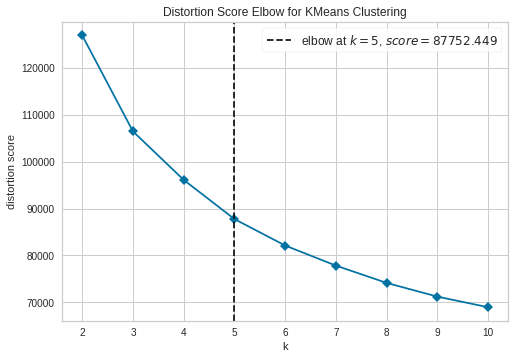

In [ ]:
plot_model(kmeans, plot = 'elbow')

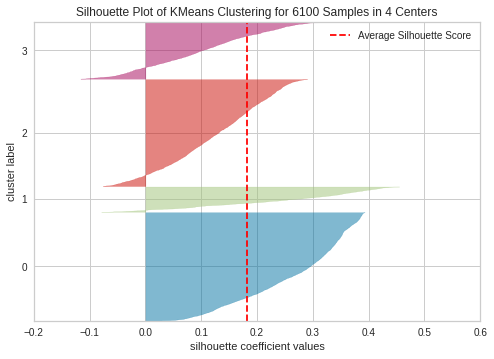

In [ ]:
plot_model(kmeans, plot = 'silhouette')

## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# **5. Interpret results and plan for actions**

In [ ]:
#kmeans_results = assign_model(kmeans)
kmeans_df = assign_model(kmeans)

In [ ]:
#kmeans_results.head()
kmeans_df

,CUST_CODE,TotalSpend,TotalUniqueVisits,FirstDate,LastDate,Recency,TotalCustomerDays,TotalActiveDays,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,SHOP_HOUR,SHOP_WEEKDAY,PurchaseConsistencyWeek,MTBP,ProportionShopWeekDay,ProportionShopHour,Total_Spend,Total_Unique_Visits,Total_Active_Week,AVG_TICKET_SIZE,AVG_ACTIVE_WEEKLY_SPEND,STD_CUST_TICKET,ProportionTopProductAmt,ProportionTopProductVal,repeat_product_index,avg_product_basket,sd_product_basket,BasketDominantMissionSpend,BasketSizeSpend,BasketTypeSpend,BasketPriceSensitivitySpend,STORE_REGION,Cluster
0,CUST0000000181,2.44,1,2007-01-06,2007-01-06,547,1.000000,1.000000,2,0,13,7,0.012797,NaN,100.000000,100.000000,2.44,1,1,2.440000,2.440000,NaN,100.000000,100.000000,1.000000,1.000000,NaN,10000,001,0100,0100,2,Cluster 0
1,CUST0000000369,959.33,217,2006-04-16,2008-07-05,1,7.883495,1.864078,2,2,21,7,0.887931,4.246073,16.130007,18.009444,959.33,217,103,4.420876,9.313883,4.123919,10.129987,12.732475,3.698413,3.221198,2.010830,12340,113,0120,1230,3,Cluster 1
2,CUST0000000689,328.57,16,2007-07-22,2008-06-23,13,26.000000,1.230769,1,0,21,7,0.260000,22.466667,20.574002,48.482819,328.57,16,13,20.535625,25.274615,19.922842,5.858721,4.864865,1.594828,11.562500,10.436914,12340,113,1230,1200,2,Cluster 3
3,CUST0000000998,5.95,3,2006-05-04,2006-07-07,730,21.666667,1.000000,0,0,15,6,0.026448,32.000000,53.949580,53.949580,5.95,3,3,1.983333,1.983333,1.187196,37.815126,25.000000,1.000000,1.333333,0.577350,01020,002,0100,1230,2,Cluster 0
4,CUST0000001163,39.74,4,2006-10-22,2008-06-22,14,152.500000,1.000000,2,0,16,7,0.044944,203.000000,54.302969,54.302969,39.74,4,4,9.935000,9.935000,11.022926,21.741319,8.000000,1.041667,6.250000,6.075909,10200,112,0120,1200,2,Cluster 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,CUST0000999593,453.58,30,2006-05-06,2008-04-02,95,26.846154,1.153846,2,3,20,7,0.229798,24.034483,27.450505,25.871952,453.58,30,26,15.119333,17.445385,9.752229,2.764672,2.356902,1.441748,9.900000,6.047798,12340,113,1230,1230,2,Cluster 3
6096,CUST0000999645,105.11,11,2006-04-30,2008-05-08,59,74.000000,1.100000,1,6,21,7,0.087719,73.900000,41.337646,38.987727,105.11,11,10,9.555455,10.511000,10.161866,9.932452,5.000000,1.304348,5.454545,7.132512,12340,113,1230,1230,3,Cluster 2
6097,CUST0000999654,5.86,1,2006-06-25,2006-06-25,742,1.000000,1.000000,1,0,14,1,0.009434,NaN,100.000000,100.000000,5.86,1,1,5.860000,5.860000,NaN,67.747440,25.000000,1.000000,4.000000,NaN,10000,000,0010,0100,3,Cluster 0
6098,CUST0000999935,444.17,21,2006-11-29,2008-06-05,31,29.210526,1.052632,1,3,21,7,0.227350,29.157895,43.631943,32.811761,444.17,21,19,21.150952,23.377368,20.343842,13.625414,4.661017,1.858268,11.238095,9.674217,12345,113,1234,1203,2,Cluster 3


In [ ]:
kmeans_df.groupby('Cluster').describe()

TotalSpend                            ... sd_product_basket                     
               count         mean          std  ...               50%       75%        max
Cluster                                         ...                                       
Cluster 0     2224.0     5.098112     6.395188  ...          0.000000  0.707107   7.778175
Cluster 1      519.0  1979.007977  1469.457446  ...          4.900193  6.810632  17.375406
Cluster 2     2198.0    64.843394    96.937675  ...          1.333059  2.645751   9.237604
Cluster 3     1159.0   275.983236   332.063795  ...          7.145127  9.409973  25.455844

[4 rows x 176 columns]

In [ ]:
summary = kmeans_df.groupby('Cluster').describe()
summary.to_excel('summary.xlsx')

##    **Finding**

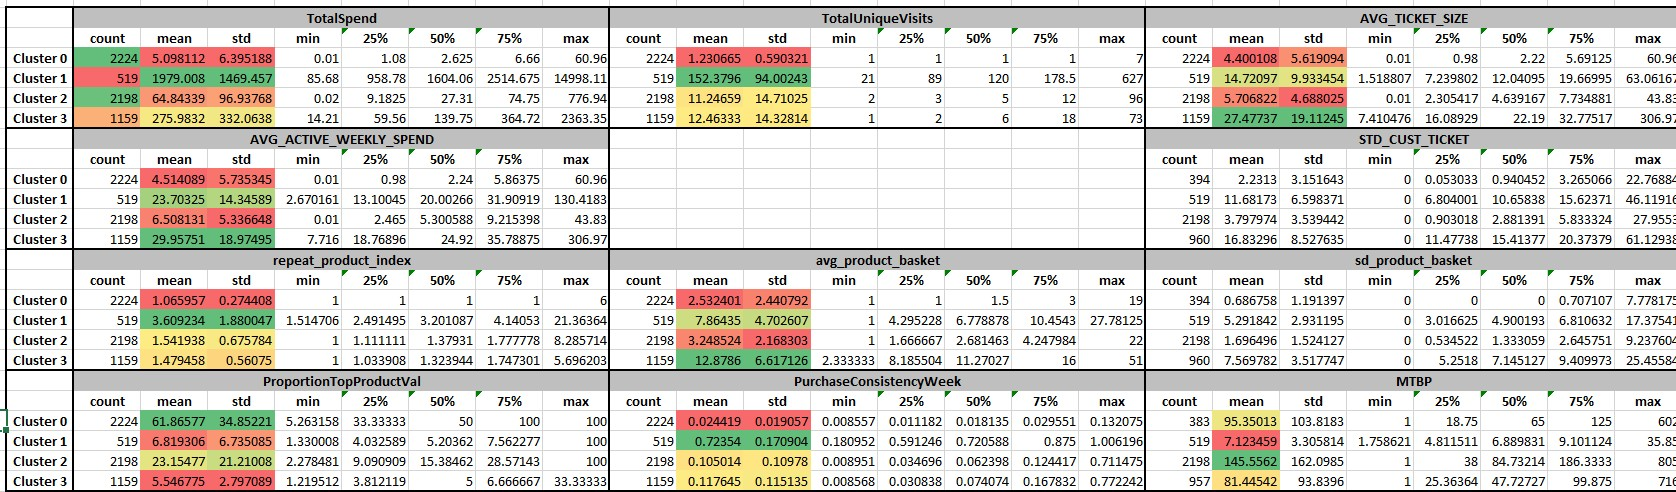

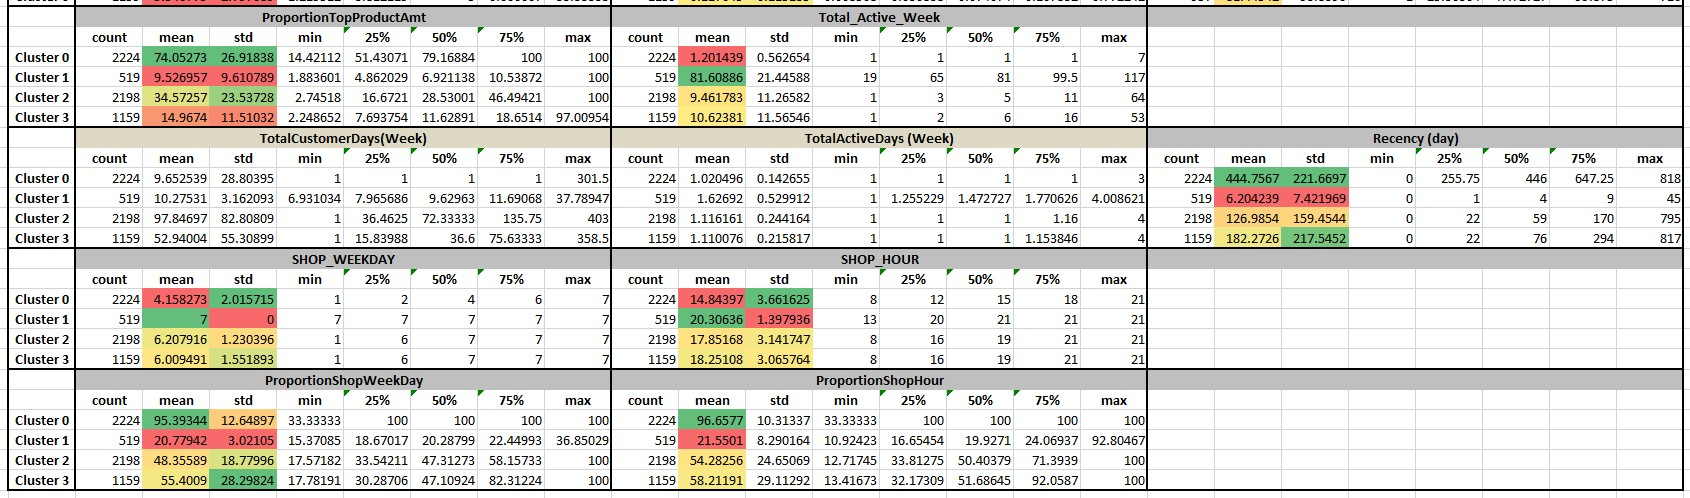

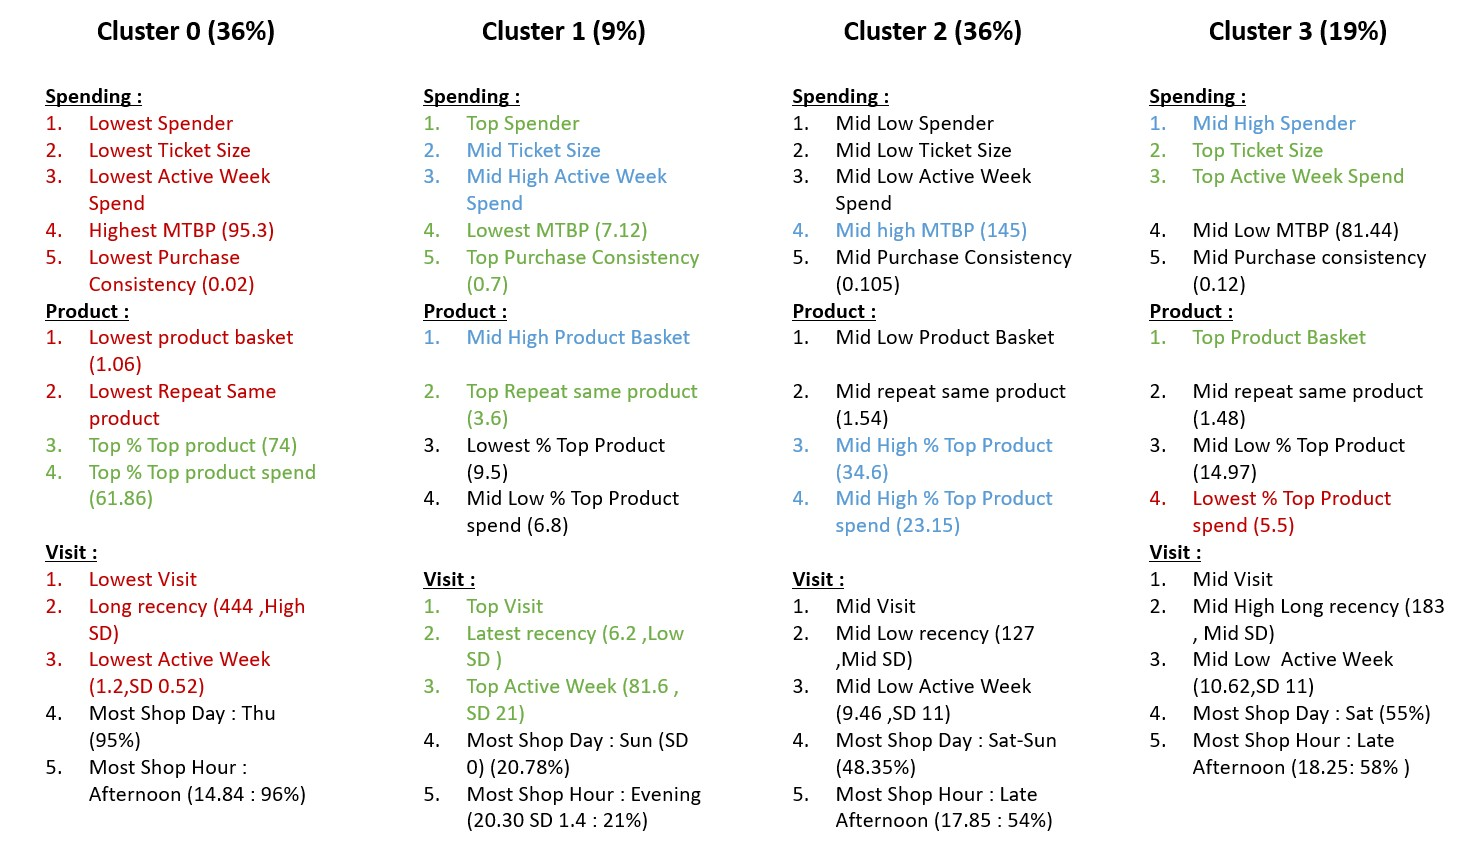

## Segmentation

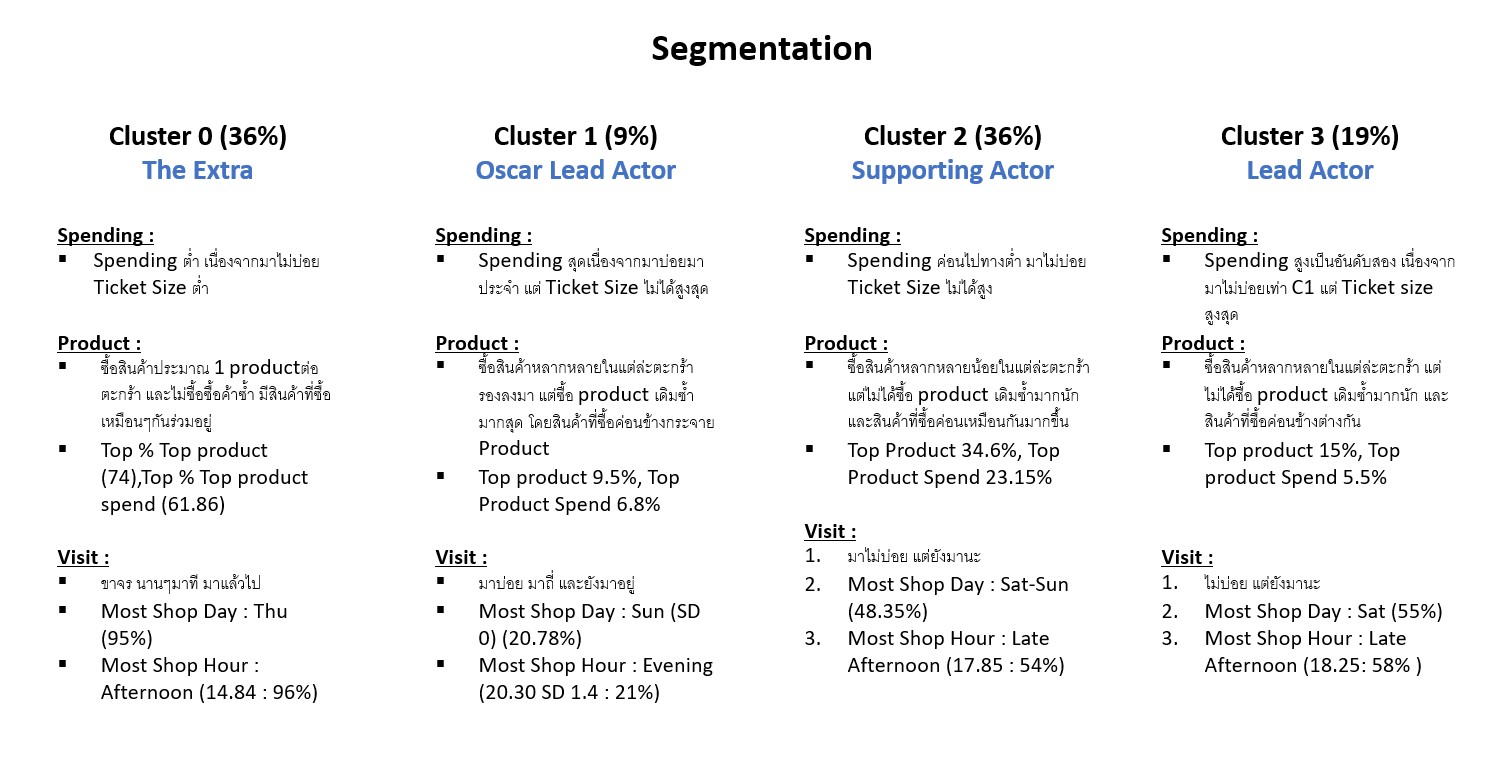

## Action

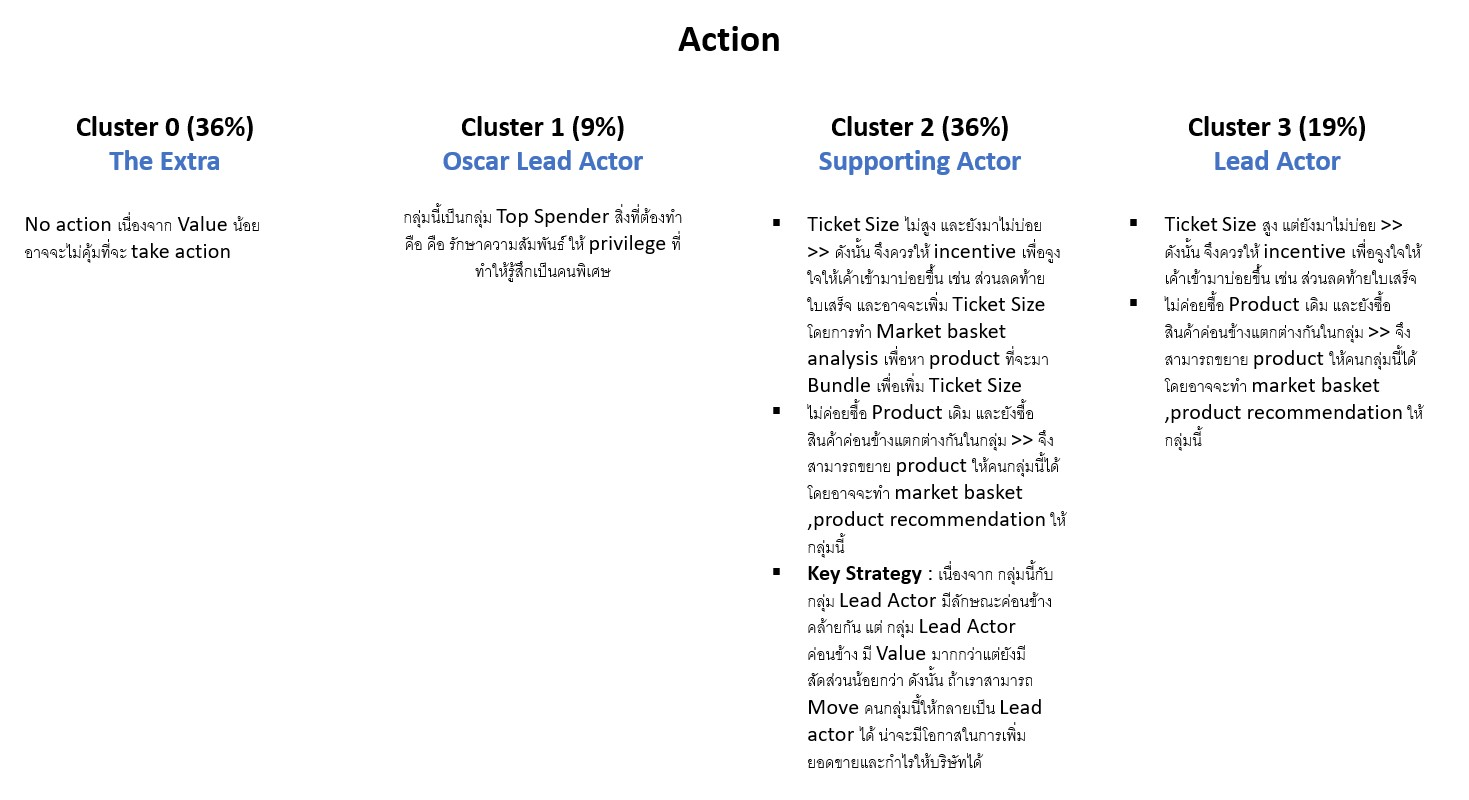